In [156]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [81]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv')


In [130]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1',parse_dates=True)

In [82]:
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [83]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [84]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [85]:
# No of users 
print("No of users : ", user_engagement_df['user_id'].nunique())
# No of logins
print("No of logins : ",len(user_engagement_df))

No of users :  8823
No of logins :  207917


#### An "adopted user" is a user who has logged into the product on three separate days in at least one seven day period 
#### identify the adopted user

In [86]:
# convert the timestamp into datetime object
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])

In [87]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [88]:
def logins_in_days(df, days=7, logins=3):
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [89]:
adopted = user_engagement_df.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'


In [90]:
adopted

user_id
1        False
2         True
3        False
4        False
5        False
         ...  
11996    False
11997    False
11998    False
11999    False
12000    False
Name: adopted_user, Length: 8823, dtype: bool

In [91]:
print("No of adopted users: ", sum(adopted), "out of total users : ", len(adopted))


No of adopted users:  1656 out of total users :  8823


In [100]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [101]:
# 5 Organizations with most users
users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [102]:
# 5 Users with most invites
users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
Name: invited_by_user_id, dtype: int64

In [131]:
# lets create a feature of user history by using creation time and last creation time
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
# calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days


In [168]:
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history
user_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0


In [169]:
users.drop('creation_time',axis=1,inplace=True)

In [ ]:
users.drop('last_session_creation_time',axis=1,inplace=True)


In [178]:
users.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history
user_id,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0


In [ ]:
# merge user data and "adopted user" variable
users = users.set_index('object_id')
users.index.name = 'user_id'



In [179]:
data = pd.concat([users, adopted], axis=1, join='inner')

In [180]:
data['adopted_user'] = data['adopted_user'].astype(int)

In [181]:
data.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,adopted_user
user_id,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,0
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,1
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0,0
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0,0


## Now lets do some EDA

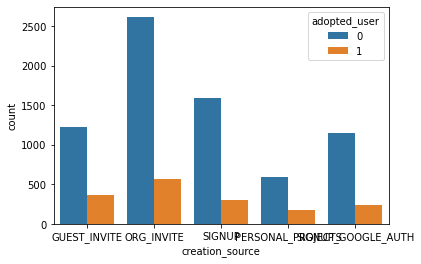

In [182]:
sns.countplot(x = 'creation_source',data = data, hue = 'adopted_user')

In [183]:
data['adopted_user'].value_counts()

0    7167
1    1656
Name: adopted_user, dtype: int64

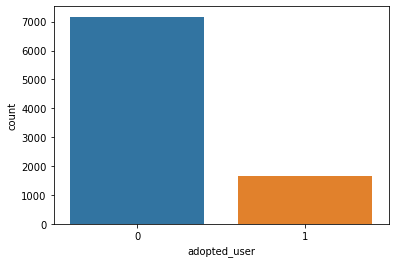

In [138]:
sns.countplot(data['adopted_user'])

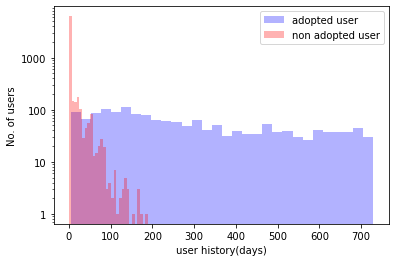

In [139]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(data, 'history', 'user history(days)')

## Model buiding

In [184]:
data['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [185]:
creation_source = pd.get_dummies(data['creation_source'],drop_first=True)

In [186]:
data.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,adopted_user
user_id,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,0
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,1
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0,0
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0,0


In [187]:
data_users_final = pd.concat([data,creation_source],axis=1)

In [188]:
data_users_final.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,adopted_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,0,0,0,0,0
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,1,1,0,0,0
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0,0,1,0,0,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0,0,0,0,0,0
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0,0,0,0,0,0


In [189]:
data_users_final.drop('creation_source',axis=1,inplace=True)

In [190]:
data_users_final.head()

,name,email,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,adopted_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,1,0,11,10803.0,0.0,0,0,0,0,0
2,Poole Matthew,MatthewPoole@gustr.com,0,0,1,316.0,136.0,1,1,0,0,0
3,Bottrill Mitchell,MitchellBottrill@gustr.com,0,0,94,1525.0,0.0,0,1,0,0,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,0,0,1,5151.0,1.0,0,0,0,0,0
5,Raw Grace,GraceRaw@yahoo.com,0,0,193,5240.0,5.0,0,0,0,0,0


In [191]:
data_users_final.drop(['name','email'],axis=1,inplace=True)

In [192]:
data_users_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   opted_in_to_mailing_list    8823 non-null   int64  
 1   enabled_for_marketing_drip  8823 non-null   int64  
 2   org_id                      8823 non-null   int64  
 3   invited_by_user_id          4776 non-null   float64
 4   history                     8823 non-null   float64
 5   adopted_user                8823 non-null   int32  
 6   ORG_INVITE                  8823 non-null   uint8  
 7   PERSONAL_PROJECTS           8823 non-null   uint8  
 8   SIGNUP                      8823 non-null   uint8  
 9   SIGNUP_GOOGLE_AUTH          8823 non-null   uint8  
dtypes: float64(2), int32(1), int64(3), uint8(4)
memory usage: 802.5 KB


In [193]:
#convert columns to float64
for col in data_users_final.columns:
    data_users_final[col] = data_users_final[col].astype('float64')

In [194]:
data_users_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   opted_in_to_mailing_list    8823 non-null   float64
 1   enabled_for_marketing_drip  8823 non-null   float64
 2   org_id                      8823 non-null   float64
 3   invited_by_user_id          4776 non-null   float64
 4   history                     8823 non-null   float64
 5   adopted_user                8823 non-null   float64
 6   ORG_INVITE                  8823 non-null   float64
 7   PERSONAL_PROJECTS           8823 non-null   float64
 8   SIGNUP                      8823 non-null   float64
 9   SIGNUP_GOOGLE_AUTH          8823 non-null   float64
dtypes: float64(10)
memory usage: 1.1 MB


In [202]:
#fill na values in invited_by_user column
data_users_final['invited_by_user_id'].fillna(value=0,inplace=True)


In [203]:
#lets use the above dataframe now and separate the target and feature variables
y = data_users_final['adopted_user']
x = data_users_final.drop('adopted_user', axis=1)

In [204]:
xtrain,xtest,ytrain,ytest = train_test_split(x, y,test_size = 0.3, random_state = 42)

In [207]:
# lets use RandomForestClassifier to handle imbalance
rand_clf = RandomForestClassifier(random_state = 42)

In [208]:
rand_clf.fit(xtrain, ytrain)


RandomForestClassifier(random_state=42)

In [212]:
rand_clf.score(xtest,ytest)

0.9595768794862108

In [214]:
imp = pd.Series(rand_clf.feature_importances_, index=x.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.871712
org_id                        0.068472
invited_by_user_id            0.039299
opted_in_to_mailing_list      0.005145
ORG_INVITE                    0.004144
enabled_for_marketing_drip    0.003692
SIGNUP                        0.002654
SIGNUP_GOOGLE_AUTH            0.002535
PERSONAL_PROJECTS             0.002348
dtype: float64


### From the above observation "history"  is of maximum importance
### it is calculatedusing the "last session creation time " and "creation time" has the mximum importance
### therefore, these are the most predicitve of future adoption of users
